In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

%matplotlib inline

Using TensorFlow backend.


# Read in the data

DATE
2017-05-01    6.8843
2017-06-01    6.8066
2017-07-01    6.7694
2017-08-01    6.6670
2017-09-01    6.5144
Name: EXCHUS, dtype: float64


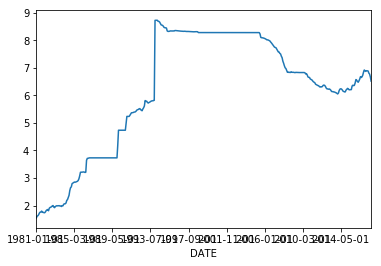

In [2]:
series = pd.read_csv('EXCHUS.csv', header=0, index_col=0, squeeze=True)
#series.loc[series == '.'] = '0.1'
series= pd.to_numeric(series)
print (series.tail())
series.plot()

# Use Augmented Dickey Fuller test to see if the time series has a trend. 

If p-value > 0.05, then accept null hypothesis that the time series is not stationary

If p-value < 0.05, then reject null hypothesis, and the time series is stationary

In [3]:
from statsmodels.tsa.stattools import adfuller
X = series.values

#try to remove variance using log transform
X = np.log(X)
result = adfuller(X)
print ('p-value is %.5f' % result[1]) #p-value

p-value is 0.00547


/Users/hechaoli/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Differencing:

Differencing is a method to remove the time dependence, which includes trends and seasonality.

p-value is 0.00000


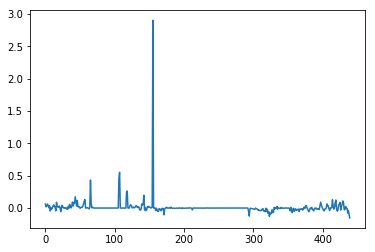

In [26]:
#manually differencing
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff = difference(X, 1)
plt.plot(diff)

"""
#using pandas function
diff = series.diff() #shift
diff.plot()
"""

result = adfuller(diff)
print ('p-value is %.5f' % result[1]) #p-value

# ARIMA model

#### AR: Autoregression. Uses the dependent relationship between an observation and some number of lagged observations
#### I: Integrated. The use of differencing of raw observations to make the time series stationary
#### MA: Moving Average. Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations


ARIMA(p,d,q):

p: number of lag observations included in the AR model -> lag order

d: number of times the raw observations are differenced -> degree of differencing

q: size of moving average window -> order of moving average

Data need to be stationary inorder to use the linear regression model

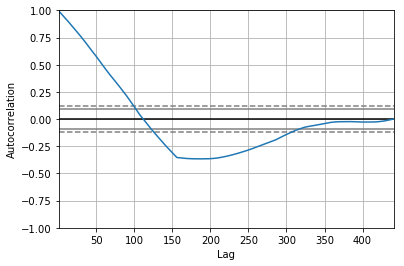

In [6]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

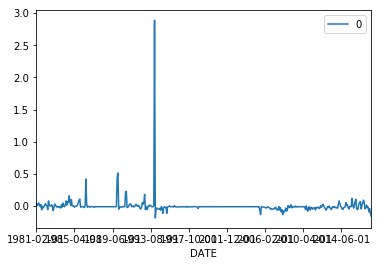

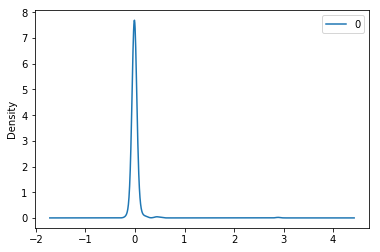

In [11]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(12, 1, 0))
model_fit = model.fit(disp=0)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

In [48]:
X = series.values
size = int(len(X)*0.8)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(12, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%.3f, expected=%.3f' % (yhat, obs))

predicted=6.840, expected=6.827
predicted=6.841, expected=6.818
predicted=6.832, expected=6.776
predicted=6.788, expected=6.787
predicted=6.801, expected=6.740
predicted=6.751, expected=6.668
predicted=6.677, expected=6.654
predicted=6.665, expected=6.650
predicted=6.663, expected=6.596
predicted=6.607, expected=6.576
predicted=6.587, expected=6.564
predicted=6.577, expected=6.527
predicted=6.538, expected=6.496
predicted=6.505, expected=6.475
predicted=6.486, expected=6.457
predicted=6.468, expected=6.404
predicted=6.411, expected=6.388
predicted=6.399, expected=6.371
predicted=6.381, expected=6.356
predicted=6.366, expected=6.348
predicted=6.359, expected=6.317
predicted=6.327, expected=6.300
predicted=6.309, expected=6.312
predicted=6.324, expected=6.304
predicted=6.315, expected=6.324
predicted=6.336, expected=6.363
predicted=6.376, expected=6.372
predicted=6.385, expected=6.359
predicted=6.370, expected=6.320
predicted=6.329, expected=6.263
predicted=6.271, expected=6.234
predicte

Test MSE: 0.00215


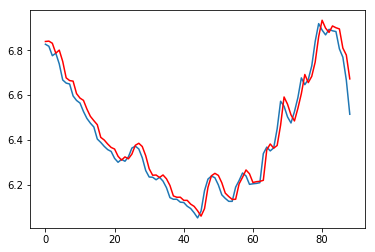

In [49]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)
plt.plot(test)
plt.plot(predictions, color='red')

In [25]:
#transform data to a sequence suit for supervised learning problem

def timeseries_to_supervised(data, lag=12):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [21]:
#differencing the data: use difference to remove the trend in the data

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

In [22]:
#invert differenced value

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [23]:
#scale the training and test data to (-1,1)

def scale(train, test):
    #fit scaler
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler= scaler.fit(train)
    
    #transform training data
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    #transform test data
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [24]:
#Invert scaling for a forecastd value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    
    return inverted[0, -1]

In [27]:
#Fit an LSTM model to training data

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X,y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, # transform data to be stationary

raw_values = series.values
diff_values = difference(raw_values, 1)

# transform the data to be supervised learning

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# spit data into training and test set

train, test = supervised_values[0:-12], supervised_values[-12:]
#print (train)

# Transform the scale of the data to [-1,1]

scaler, train_scaled, test_scaled = scale(train, test)

#fit the model

lstm_model = fit_lstm(train_scaled, 1, 2500, 4)

# forecast the entire training dataset to build up state for forecasting

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False) #we need the data in sequential order
        model.reset_states()
    
    return model

In [32]:
#make one-step forecast

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [33]:
# transform data to be stationary

raw_values = series.values
diff_values = difference(raw_values, 1)

In [35]:
# transform the data to be supervised learning

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [36]:
# spit data into training and test set

train, test = supervised_values[0:size], supervised_values[size:]
#print (train)

In [37]:
# Transform the scale of the data to [-1,1]

scaler, train_scaled, test_scaled = scale(train, test)

In [38]:
#fit the model

lstm_model = fit_lstm(train_scaled, 1, 200, 6)

In [39]:
# forecast the entire training dataset to build up state for forecasting

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.85458052],
       [-0.87493575],
       [-0.90505528],
       [-0.90244716],
       [-0.89840901],
       [-0.90674996],
       [-0.91370726],
       [-0.90624285],
       [-0.92964184],
       [-0.91418213],
       [-0.92388999],
       [-0.91936398],
       [-0.91330844],
       [-0.91135269],
       [-0.91902494],
       [-0.91975129],
       [-0.93440908],
       [-0.89727169],
       [-0.92281532],
       [-0.92136544],
       [-0.92071486],
       [-0.91669726],
       [-0.92336422],
       [-0.93896246],
       [-0.92573309],
       [-0.913378  ],
       [-0.9239043 ],
       [-0.92350966],
       [-0.92693347],
       [-0.92368096],
       [-0.92556369],
       [-0.92887962],
       [-0.92422289],
       [-0.93129009],
       [-0.91744137],
       [-0.92875946],
       [-0.9113332 ],
       [-0.92685521],
       [-0.92622626],
       [-0.91892773],
       [-0.90495211],
       [-0.92519152],
       [-0.9072938 ],
       [-0.9140504 ],
       [-0.88820487],
       [-0

In [40]:
# walk-forward validation on the test data

predictions = list()

for i in range(len(test_scaled)):
    
    #make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    
    #invert scaling
    yhat = invert_scale(scaler, X, yhat)
    
    #invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    
    #store forecast
    predictions.append(yhat)
    expected = raw_values[len(train)+i+1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=6.811742, Expected=6.818400
Month=2, Predicted=6.798153, Expected=6.776200
Month=3, Predicted=6.744657, Expected=6.787300
Month=4, Predicted=6.779684, Expected=6.739600
Month=5, Predicted=6.703011, Expected=6.667800
Month=6, Predicted=6.629329, Expected=6.653800
Month=7, Predicted=6.639498, Expected=6.649700
Month=8, Predicted=6.632048, Expected=6.596400
Month=9, Predicted=6.559686, Expected=6.576100
Month=10, Predicted=6.557878, Expected=6.564500
Month=11, Predicted=6.545111, Expected=6.526700
Month=12, Predicted=6.496657, Expected=6.495700
Month=13, Predicted=6.471516, Expected=6.474600
Month=14, Predicted=6.453019, Expected=6.457500
Month=15, Predicted=6.436339, Expected=6.403600
Month=16, Predicted=6.368145, Expected=6.388500
Month=17, Predicted=6.372084, Expected=6.371000
Month=18, Predicted=6.348759, Expected=6.356400
Month=19, Predicted=6.335967, Expected=6.348200
Month=20, Predicted=6.330014, Expected=6.317200
Month=21, Predicted=6.289555, Expected=6.299700
M

Test MSE: 0.00175


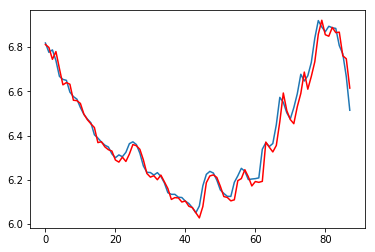

In [47]:
error = mean_squared_error(raw_values[size+1:], predictions)
print('Test MSE: %.5f' % error)
plt.plot(raw_values[size+1:])
plt.plot(predictions, color='red')